In [6]:
%run -m celldom.nb.logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from cvutils.visualize import display_images

from celldom.core import cytometry
from celldom.core.experiment import Experiment
from celldom.execute import view
from celldom.config.experiment_config import ExperimentConfig

config_path = '/lab/repos/celldom/config/experiment/exp-20181121-ML-FL-Sample.yaml'
output_dir = '/lab/data/celldom/output/20181218-MLFL-full'

In [2]:
exp = Experiment(ExperimentConfig(config_path), output_dir)
exp

Name: exp-20181121-ML-FL-Sample
Path: /lab/data/celldom/output/20181218-MLFL-full
Chip: ML01
Analysis: Default

In [3]:
view.build_all(exp)

In [4]:
df_apt = exp.get_view_store().get('apartment')
df_apt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11996 entries, 0 to 11995
Data columns (total 31 columns):
acq_apartment             11996 non-null object
acq_channel               11996 non-null object
acq_cohort                11996 non-null object
acq_datetime              11996 non-null datetime64[ns]
acq_day                   11996 non-null object
acq_id                    11996 non-null object
acq_processed_at          11996 non-null datetime64[ns]
acq_street                11996 non-null object
apt_id                    11996 non-null int64
apt_image_height          11996 non-null int64
apt_image_width           11996 non-null int64
apt_num                   11996 non-null object
apt_num_digit_scores      11996 non-null object
cell_count                11996 non-null float64
focus_score               11996 non-null int64
marker_center_x           11996 non-null int64
marker_center_y           11996 non-null int64
occupancy_chamber         11996 non-null float64
occupancy_trap 

In [5]:
df_cell = exp.get_view_store().get('cell')
df_cell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13696 entries, 0 to 13695
Data columns (total 31 columns):
acq_apartment          13696 non-null object
acq_channel            13696 non-null object
acq_cohort             13696 non-null object
acq_datetime           13696 non-null datetime64[ns]
acq_day                13696 non-null object
acq_id                 13696 non-null object
acq_processed_at       13696 non-null datetime64[ns]
acq_street             13696 non-null object
apt_id                 13696 non-null int64
apt_num                13696 non-null object
area                   13696 non-null int64
cell_id                13696 non-null int64
centroid_x             13696 non-null float64
centroid_y             13696 non-null float64
eccentricity           13696 non-null float64
expr_CY5               13696 non-null float64
expr_GFP               13696 non-null float64
in_chamber             13696 non-null bool
in_trap                13696 non-null bool
roi_xmax              

In [7]:
df_cell.filter(regex='expr').describe()

,expr_CY5,expr_GFP
count,13696.000000,13696.000000
mean,71.474486,128.013458
std,74.631755,116.921756
min,0.000000,0.000000
25%,0.000000,0.333333
50%,58.266086,191.045032
75%,138.159018,245.962747
max,255.000000,255.000000


Show GFP vs CY5 at time zero only:

Text(0.5,1,'CY5 vs GFP for all cells at time 0')

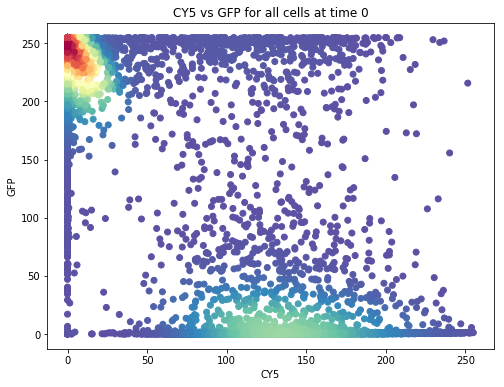

In [147]:
from scipy.stats import gaussian_kde

x = df_cell[df_cell.elapsed_hours_group == 0]['expr_CY5']
y = df_cell[df_cell.elapsed_hours_group == 0]['expr_GFP']
dens = gaussian_kde(np.vstack([x, y]))(np.vstack([x, y]))
plt.scatter(x, y, c=dens, cmap='Spectral_r')
ax = plt.gca()
ax.set_xlabel('CY5')
ax.set_ylabel('GFP')
plt.gcf().set_size_inches(8, 6)
ax.set_title('CY5 vs GFP for all cells at time 0')

In [116]:
df = pd.concat([
    (
        df_cell
        .query('elapsed_hours_group == 0')
        .assign(type=lambda df: np.where(df['expr_CY5'] > df['expr_GFP'], 'CY5+', 'GFP+'))
        .groupby(exp.config.apartment_address_fields + ['type'])['in_chamber'].sum()
        .unstack().fillna(0)
    ),
    (
        df_apt
        .query('elapsed_hours_group == 0')
        .groupby(exp.config.apartment_address_fields).first().filter(regex='acq_|apt_id')
    )
], axis=1)
df.head()

CY5+  GFP+ acq_apartment acq_channel  \
acq_cohort      apt_num st_num                                         
1000mbarsqueeze 000     000      1.0   0.0           000          BF   
                        001      0.0   0.0           000          BF   
                        002      0.0   1.0           000          BF   
                        003      1.0   1.0           000          BF   
                        004      0.0   0.0           000          BF   

                                      acq_datetime acq_day  \
acq_cohort      apt_num st_num                               
1000mbarsqueeze 000     000    2018-11-21 14:12:41       0   
                        001    2018-11-21 14:12:41       0   
                        002    2018-11-21 14:12:41       0   
                        003    2018-11-21 14:12:41       0   
                        004    2018-11-21 14:12:41       0   

                                                          acq_id  \
acq_cohort      apt_num st_num                                     
1000mbarsqueeze 000     000     2ee805704392f20d9a12ab606c7c07ce   
                        001     2ee805704392f20d9a12ab606c7c07ce   
                        002     2ee805704392f20d9a12ab606c7c07ce   
                        003     2ee805704392f20d9a12ab606c7c07ce   
                        004     2ee805704392f20d9a12ab606c7c07ce   

                                  acq_processed_at acq_street  apt_id  \
acq_cohort      apt_num st_num                                          
1000mbarsqueeze 000     000    2018-12-18 15:17:08        000      30   
                        001    2018-12-18 15:17:08        000      14   
                        002    2018-12-18 15:17:08        000       0   
                        003    2018-12-18 15:17:08        000      16   
                        004    2018-12-18 15:17:08        000      26   

                                acq_datetime_group  
acq_cohort      apt_num st_num                      
1000mbarsqueeze 000     000    2018-11-21 14:12:41  
                        001    2018-11-21 14:12:41  
                        002    2018-11-21 14:12:41  
                        003    2018-11-21 14:12:41  
                        004    2018-11-21 14:12:41

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11996 entries, (1000mbarsqueeze, 000, 000) to (presqueeze, 845, 015)
Data columns (total 11 columns):
CY5+                  11292 non-null float64
GFP+                  11292 non-null float64
acq_apartment         11996 non-null object
acq_channel           11996 non-null object
acq_datetime          11996 non-null datetime64[ns]
acq_day               11996 non-null object
acq_id                11996 non-null object
acq_processed_at      11996 non-null datetime64[ns]
acq_street            11996 non-null object
apt_id                11996 non-null int64
acq_datetime_group    11996 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1), object(5)
memory usage: 1.1+ MB


In [118]:
def pivot(g):
    return g[['CY5+', 'GFP+']].fillna(0).astype(int).groupby(['CY5+', 'GFP+']).size().unstack()
df.groupby(exp.config.experimental_condition_fields).apply(pivot).fillna(0).astype(int).style\
    .background_gradient(high=.6, low=.4, cmap='viridis')\
    .set_caption('Apartment count by number of cells by type (at time 0)')

In [119]:
def pivot(g):
    n = len(g)
    return g[['CY5+', 'GFP+']].fillna(0).astype(int).groupby(['CY5+', 'GFP+']).size().unstack()/ n
df.groupby(exp.config.experimental_condition_fields).apply(pivot).fillna(0).style\
    .background_gradient(high=1, low=.8, cmap='viridis')\
    .format('{:.1%}')\
    .set_caption('Apartment percentages by number of cells by type (at time 0)')

In [149]:
image_store = exp.get_image_store()

df_img = []
keys = ['acq_id', 'apt_id', 'acq_datetime']

for _, r in df[(df['CY5+'] == 1) & (df['GFP+'] == 1)].reset_index().head(10).iterrows():
    idx = tuple(r[keys])
    cells = df_cell.set_index(keys).loc[[idx]]
    img = gray2rgb(image_store.load_image(cytometry.get_image_key('apartment', 'apt_image', r)))
    
    for ic, cr in cells.iterrows():
        rr, cc = circle_perimeter(int(cr['centroid_y']), int(cr['centroid_x']), 8, shape=img.shape[:2])
        img[rr, cc] = [
            min(int(cr['expr_CY5'] * 4), 255), 
            min(int(cr['expr_GFP'] * 1), 255), 
            0
        ]
        
    df_img.append(dict(
        apt_num=r['apt_num'],
        st_num=r['st_num'],
        datetime=r['acq_datetime'],
        image=img
    ))
df_img = pd.DataFrame(df_img)
df_img

,apt_num,datetime,image,st_num
0,000,2018-11-21 14:12:41,"[[[167, 167, 167], [164, 164, 164], [162, 162,...",003
1,000,2018-11-21 14:12:44,"[[[176, 176, 176], [175, 175, 175], [174, 174,...",008
2,000,2018-11-21 14:12:47,"[[[174, 174, 174], [174, 174, 174], [171, 171,...",014
3,000,2018-11-21 14:12:47,"[[[168, 168, 168], [164, 164, 164], [163, 163,...",015
4,000,2018-11-21 14:12:53,"[[[168, 168, 168], [167, 167, 167], [167, 167,...",025
5,000,2018-11-21 14:12:56,"[[[164, 164, 164], [164, 164, 164], [163, 163,...",033
6,000,2018-11-21 14:12:59,"[[[165, 165, 165], [166, 166, 166], [166, 166,...",039
7,000,2018-11-21 14:13:02,"[[[108, 108, 108], [108, 108, 108], [107, 107,...",047
8,000,2018-11-21 14:13:05,"[[[167, 167, 167], [167, 167, 167], [167, 167,...",051
9,000,2018-11-21 14:13:08,"[[[173, 173, 173], [171, 171, 171], [171, 171,...",055


Show a few apartments with one GFP+ and one CY5+ cell:

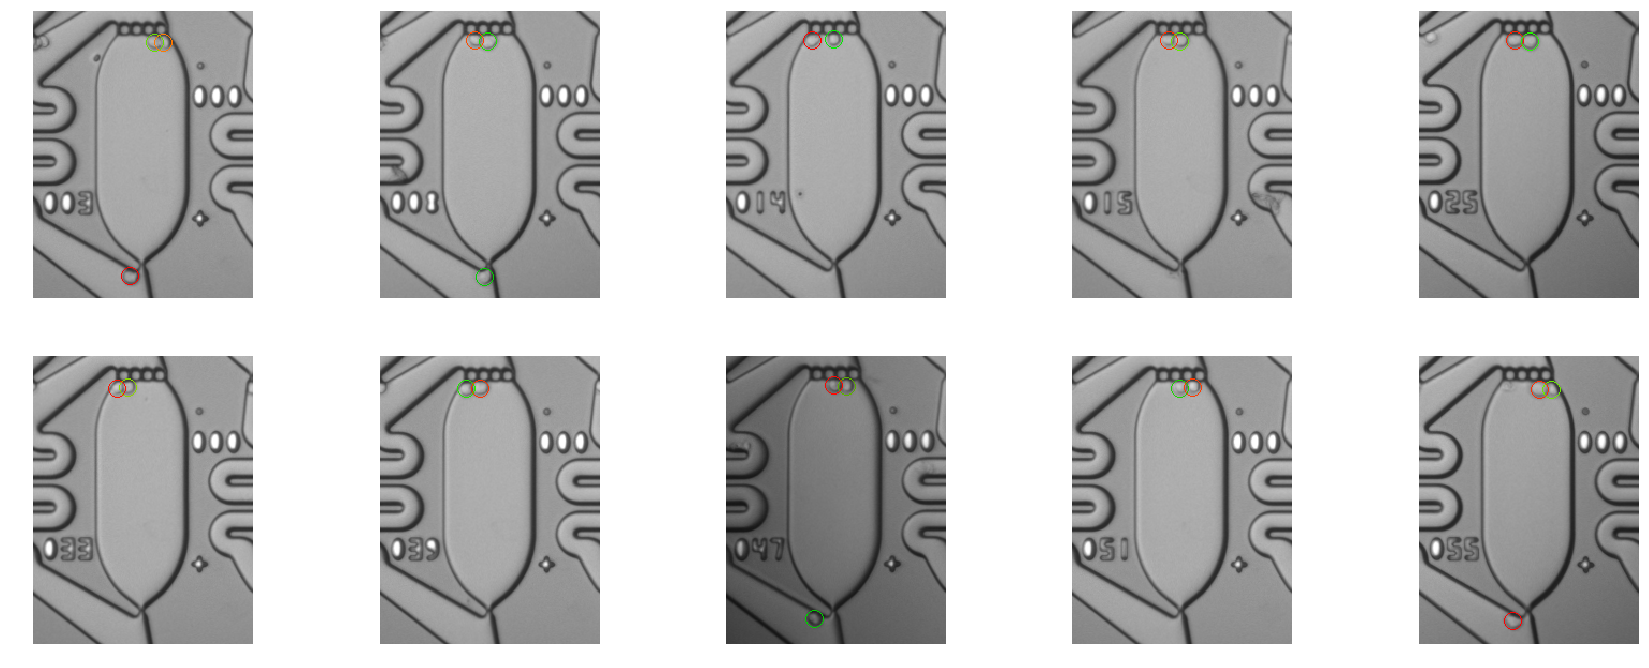

In [150]:
display_images(df_img['image'], size=30, cols=5)